In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [4]:
from ase.filters import FrechetCellFilter
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor
from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator
from fairchem.core import pretrained_mlip, FAIRChemCalculator
# from mace.calculators import mace_mp # need e3nn 0.4.4
# from sevenn.calculator import SevenNetCalculator # need e3nn 0.5.0 later change numpy to 1.26.4
from mattersim.forcefield import MatterSimCalculator

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [5]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

In [6]:
MODEL = "uma" # "orb" or "uma" or "mace" or "seven" or "mattersim"

In [7]:
# orb_ff = pretrained.orb_v3_conservative_inf_omat(device="cuda",precision="float32-high")   # or "float32-highest" / "float64
# orb_calc = ORBCalculator(orb_ff, device="cuda")

uma_ff = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
uma_calc = FAIRChemCalculator(uma_ff, task_name="omat")

# # mace_calc = mace_mp(model="MACE-matpes-r2scan-omat-ft.model", dispersion=False, device='cuda')

# seven_calc = SevenNetCalculator('7net-mf-ompa', modal='omat24')

# mattersim_calc = MatterSimCalculator(device="cuda")

MODELS = {
    # "orb":orb_calc,
    "uma":uma_calc,
    # "mace":mace_calc,
    # "seven":seven_calc,
    # "mattersim":mattersim_calc,
}

In [14]:
# Function used to relax initial primitive cell and for competing phase calculation, full relaxation using FrechetCellFilter
def relax_structure(structure):
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(FrechetCellFilter(atoms)) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    relaxed_structure = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()
    energy_per_atom = energy / len(atoms)

    return relaxed_structure, energy_per_atom 
    

In [21]:
# Function that relaxes defect and pristine supercells, ensuring a fixed lattice by no FrechetCellFilter
def relax_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    relaxed_structure = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()
    energy_per_atom = energy / len(atoms)

    return relaxed_structure, energy_per_atom

## Relaxation of Primitive Al Cells

In [11]:
matching_pairs = loadfn('../../data/matching_AlCr_ox.json')

In [15]:
relaxed_Al_prim = {}
for name, val in matching_pairs.items():
    structure, energy = relax_structure(val['structure'])
    relaxed_Al_prim[name] = {
        'formula': val['formula'],
        'energy': energy,
        'structure': structure
    }

       Step     Time          Energy          fmax
LBFGS:    0 18:45:16     -380.434092        0.808930
LBFGS:    1 18:45:16     -380.590292        0.524302


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.711360190712929e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:45:17     -380.685107        0.379665


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.66870987942106e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:45:18     -380.725912        0.335461


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.700223972721688e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:45:18     -380.755026        0.294176


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.702837920263563e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:45:19     -380.778330        0.275428


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.711686382591534e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:45:19     -380.796622        0.261812


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.77106984227037e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:45:20     -380.817912        0.245287


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.75151059019503e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:45:20     -380.838694        0.218163


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.717488085470356e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:45:21     -380.854315        0.191684


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.804695073491913e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:45:21     -380.866446        0.170794


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.722686364671865e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:45:22     -380.881106        0.179030


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.747831037519805e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:45:22     -380.901823        0.249147


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.806648325600483e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:45:23     -380.926115        0.255925


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.760018199548577e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:45:23     -380.946432        0.235878


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.734918004422481e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:45:24     -380.960665        0.178671


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.77483776784936e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:45:25     -380.973112        0.211813


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.868101270336547e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:45:25     -380.987170        0.188844


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.824758990807256e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:45:26     -380.999091        0.149053


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.76315400604995e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   19 18:45:26     -381.005816        0.121512


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.832547870695885e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 18:45:27     -381.009905        0.108916


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.823762949118513e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   21 18:45:27     -381.014395        0.107846


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.790000289378599e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 18:45:28     -381.020960        0.115259


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.78908010786989e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 18:45:28     -381.029078        0.140805


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.857928559087989e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   24 18:45:29     -381.036848        0.123362


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.841084395494688e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 18:45:29     -381.041899        0.110524


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.826631678581996e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   26 18:45:30     -381.044886        0.104640


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.848162999404502e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 18:45:30     -381.047415        0.087241


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.848309028709635e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   28 18:45:31     -381.050566        0.073107


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.887134662886014e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 18:45:32     -381.053370        0.070912


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.863533227717301e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   30 18:45:32     -381.055365        0.061020


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.833140830689788e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 18:45:33     -381.056872        0.073995


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.812338521991348e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   32 18:45:33     -381.058333        0.065444


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.942945922507899e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   33 18:45:34     -381.059878        0.064606


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.889177738002131e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   34 18:45:34     -381.061079        0.037694


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.854215926785952e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   35 18:45:35     -381.061854        0.039523


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.874271967503737e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   36 18:45:35     -381.062663        0.043238


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.884921881552847e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   37 18:45:36     -381.063673        0.048823


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.848304540844286e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   38 18:45:36     -381.064696        0.039364


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.866610811513224e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   39 18:45:37     -381.065276        0.026463


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.864141348195465e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   40 18:45:37     -381.065615        0.021815


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.896961732306552e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   41 18:45:38     -381.065955        0.024817


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.86648568683035e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   42 18:45:38     -381.066241        0.023993


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.896147585155204e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   43 18:45:39     -381.066424        0.018700


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.859573341288532e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   44 18:45:40     -381.066561        0.016975


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.846681904607623e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   45 18:45:40     -381.066729        0.017885


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.932882673642868e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   46 18:45:41     -381.066908        0.018848


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.879791559536633e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   47 18:45:41     -381.067046        0.017457


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.849479833367225e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   48 18:45:42     -381.067141        0.017832


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.856770790277071e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   49 18:45:42     -381.067263        0.018386


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.881603957606281e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   50 18:45:43     -381.067408        0.018315


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.87992195341725e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   51 18:45:43     -381.067564        0.017320


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.841759221891443e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   52 18:45:44     -381.067744        0.015671


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.849505482603663e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   53 18:45:44     -381.067904        0.016373


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.871832251931288e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   54 18:45:45     -381.068068        0.018885


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.896922606840215e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   55 18:45:46     -381.068198        0.019441


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.872748519888248e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   56 18:45:46     -381.068301        0.016200


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.880369057893276e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   57 18:45:47     -381.068392        0.013263


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.885240842353011e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   58 18:45:47     -381.068499        0.016985


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.847224563553764e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   59 18:45:48     -381.068613        0.015848


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.827164029948909e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   60 18:45:48     -381.068701        0.010539


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.828940091294736e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   61 18:45:49     -381.068770        0.010330


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.849845165638627e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   62 18:45:50     -381.068835        0.011385


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.842050984208882e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   63 18:45:50     -381.068930        0.015038


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.912579448389551e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   64 18:45:51     -381.069064        0.018372


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.840685693922731e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   65 18:45:51     -381.069212        0.020819


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.962558099295188e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   66 18:45:52     -381.069331        0.015819


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.909169669708913e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   67 18:45:52     -381.069399        0.011643


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.891754898497012e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   68 18:45:53     -381.069456        0.007569


/tmp/ipykernel_325/1103831978.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
  energy_per_atom = energy / atoms.get_number_of_atoms()


       Step     Time          Energy          fmax
LBFGS:    0 18:45:53      -26.444063        0.385959
LBFGS:    1 18:45:54      -26.451408        0.316382
LBFGS:    2 18:45:54      -26.463084        0.203199
LBFGS:    3 18:45:54      -26.465172        0.219256
LBFGS:    4 18:45:55      -26.470320        0.130670
LBFGS:    5 18:45:55      -26.471066        0.041673
LBFGS:    6 18:45:56      -26.471208        0.043587
LBFGS:    7 18:45:56      -26.471283        0.045533
LBFGS:    8 18:45:56      -26.471447        0.040158
LBFGS:    9 18:45:57      -26.471587        0.030718
LBFGS:   10 18:45:57      -26.471654        0.012509
LBFGS:   11 18:45:57      -26.471662        0.001890
       Step     Time          Energy          fmax
LBFGS:    0 18:45:58      -35.136176        0.418706
LBFGS:    1 18:45:58      -35.143677        0.370641
LBFGS:    2 18:45:59      -35.164570        0.099606
LBFGS:    3 18:45:59      -35.165521        0.092851
LBFGS:    4 18:46:00      -35.169802        0.1443

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036464e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    1 18:46:28     -311.060609        0.014720


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3695646736856616e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:46:29     -311.060663        0.013447


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.336290033691264e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:46:29     -311.060697        0.012410


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3588149309288854e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:46:30     -311.060747        0.011653


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.343472700428871e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:46:30     -311.060811        0.013980


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3503458703346727e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:46:31     -311.060918        0.022598


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3685884731264315e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:46:31     -311.061040        0.021831


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3241267299564467e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:46:32     -311.061143        0.016625


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3180117396512827e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:46:32     -311.061239        0.014255


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3229391197377124e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:46:33     -311.061326        0.015071


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3124661199458774e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:46:33     -311.061437        0.021148


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3331509098610617e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:46:34     -311.061521        0.017844


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3389627103198465e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:46:35     -311.061609        0.014213


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3238356106182077e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:46:35     -311.061674        0.014648


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.334796718499429e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:46:36     -311.061750        0.014518


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3670301728243316e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:46:36     -311.061822        0.011472


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.334679598249399e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:46:37     -311.061876        0.011553


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.380219791578499e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:46:37     -311.061914        0.008957
       Step     Time          Energy          fmax
LBFGS:    0 18:46:38     -426.244263        0.038023


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.206309008500078e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    1 18:46:38     -426.244587        0.036861


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.277064164411457e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:46:39     -426.244934        0.036234


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.223555177331126e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:46:40     -426.245526        0.044657


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.30970074721774e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:46:40     -426.246525        0.059054


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.237535526329543e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:46:41     -426.247883        0.051906


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.250045641051786e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:46:41     -426.249203        0.056169


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.238981702124339e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:46:42     -426.250019        0.059450


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.248139292107507e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:46:43     -426.250519        0.059347


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.198362598260916e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:46:43     -426.251038        0.057334


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.257427468614185e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:46:44     -426.252064        0.053584


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.220871978264477e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:46:44     -426.253437        0.084468


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.18583774865023e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:46:45     -426.255009        0.095150


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.236113633688956e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:46:46     -426.256318        0.069325


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.304788180036287e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:46:46     -426.257286        0.049380


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.266563630242944e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:46:47     -426.258057        0.050125


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.207475659035641e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:46:48     -426.258927        0.057230


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.307046052377463e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:46:48     -426.260220        0.086548


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.291133744602552e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:46:49     -426.262230        0.101612


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.274831505177086e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   19 18:46:49     -426.264973        0.086268


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.248369086063915e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 18:46:50     -426.267689        0.067511


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.289194574381864e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   21 18:46:50     -426.269444        0.057645


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.333772425878044e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 18:46:51     -426.270440        0.046006


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.338466829027073e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 18:46:52     -426.271580        0.046276


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.356222257603104e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   24 18:46:52     -426.273899        0.080722


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.356623255004038e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 18:46:53     -426.277672        0.111919


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.336225551170311e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   26 18:46:54     -426.282174        0.114122


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.446001263909601e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 18:46:54     -426.285187        0.073736


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.425283441147778e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   28 18:46:55     -426.286419        0.051567


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.4353958107522e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 18:46:55     -426.286976        0.043256


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.40492542746042e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   30 18:46:56     -426.287560        0.043243


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.423524194370196e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 18:46:57     -426.288472        0.050683


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.420487957828834e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   32 18:46:57     -426.289433        0.041383


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.453805937850511e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   33 18:46:58     -426.290177        0.033784


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.38455778807908e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   34 18:46:58     -426.290497        0.023805


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.435027527942586e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   35 18:46:59     -426.290635        0.017055


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.464521760028919e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   36 18:47:00     -426.290818        0.024421


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.513138201540506e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   37 18:47:00     -426.291180        0.031177


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.466814623672314e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   38 18:47:01     -426.291916        0.042931


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.484131910115582e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   39 18:47:01     -426.293103        0.049129


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.455201507028298e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   40 18:47:02     -426.294220        0.039706
LBFGS:   41 18:47:03     -426.294777        0.032765
LBFGS:   42 18:47:03     -426.294957        0.020509
LBFGS:   43 18:47:04     -426.295105        0.020569
LBFGS:   44 18:47:04     -426.295338        0.020203
LBFGS:   45 18:47:05     -426.295735        0.048830
LBFGS:   46 18:47:06     -426.296204        0.076152
LBFGS:   47 18:47:06     -426.296837        0.092154
LBFGS:   48 18:47:07     -426.297661        0.087501
LBFGS:   49 18:47:07     -426.298577        0.058021
LBFGS:   50 18:47:08     -426.299179        0.026926
LBFGS:   51 18:47:09     -426.299405        0.023998
LBFGS:   52 18:47:09     -426.299504        0.014881
LBFGS:   53 18:47:10     -426.299584        0.014899
LBFGS:   54 18:47:10     -426.299755        0.019918
LBFGS:   55 18:47:11     -426.300034        0.031632
LBFGS:   56 18:47:12     -426.300476        0.053123
LBFGS:   57 18:47:12     -426.300965        0.063142
LBFGS:   58 18:47:13     -426.301358        0.

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036463e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    1 18:47:50     -212.371911        0.214873


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.340888259775454e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:47:50     -212.386930        0.210037


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3381622969462325e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:47:51     -212.406667        0.094754


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3418297574147043e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:47:51     -212.409595        0.091127


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3870578897981124e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:47:52     -212.416517        0.092528


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.410629633932824e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:47:53     -212.421113        0.103741


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.332072990936096e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:47:53     -212.423664        0.079783


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.374068910234955e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:47:54     -212.424468        0.078489


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3707245228529283e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:47:54     -212.425348        0.077266


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3290594696850773e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:47:55     -212.427322        0.085479


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3510663509665753e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:47:55     -212.431838        0.159412


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.378682294488665e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:47:56     -212.440710        0.228948


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3938849007188266e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:47:57     -212.453189        0.228756


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4111881492715783e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:47:57     -212.462800        0.125434


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.399137970544131e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:47:58     -212.466567        0.085813


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.385111426788794e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:47:58     -212.468463        0.077948


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.403357765977618e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:47:59     -212.470994        0.094702


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4073393677561546e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:48:00     -212.474439        0.113460


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3885506536858316e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   19 18:48:00     -212.477609        0.083321


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.388004307293356e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 18:48:01     -212.479070        0.041325


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4180640366695696e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   21 18:48:01     -212.479560        0.035701


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.406687952904353e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 18:48:02     -212.480047        0.043478


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3791879758849326e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 18:48:03     -212.480905        0.055369


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4215889641752747e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   24 18:48:03     -212.481927        0.051612


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3945084969056434e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 18:48:04     -212.482599        0.026305


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.498039328015102e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   26 18:48:04     -212.482810        0.016534


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4133357781926605e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 18:48:05     -212.482896        0.016237


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.45718497623853e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   28 18:48:06     -212.483043        0.018083


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4588166703018653e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 18:48:06     -212.483304        0.027208


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4268667989538055e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   30 18:48:07     -212.483638        0.027705


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.47056647587331e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 18:48:07     -212.483905        0.020504


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4350380745426423e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   32 18:48:08     -212.484052        0.016695


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4776921792447874e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   33 18:48:09     -212.484161        0.014612


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.445579048161513e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   34 18:48:09     -212.484264        0.014745


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4523127325011614e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   35 18:48:10     -212.484380        0.014641


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.401001814958525e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   36 18:48:10     -212.484495        0.018270


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4002664637476025e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   37 18:48:11     -212.484659        0.022002


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.486047012047037e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   38 18:48:11     -212.484924        0.026346


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4225295574061817e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   39 18:48:12     -212.485404        0.037064


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.404945313728558e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   40 18:48:13     -212.486042        0.036333


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4048677411194927e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   41 18:48:14     -212.486515        0.020646


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4517404797843727e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   42 18:48:14     -212.486740        0.016343


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4608327317414097e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   43 18:48:15     -212.486888        0.016644


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4334443048194025e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   44 18:48:15     -212.487133        0.022819


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.379741867218906e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   45 18:48:16     -212.487554        0.031160


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.487352488548058e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   46 18:48:17     -212.488050        0.028432


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.492929072593984e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   47 18:48:17     -212.488330        0.013432


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.452287870604598e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   48 18:48:18     -212.488395        0.012327


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.441326255977175e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   49 18:48:18     -212.488426        0.012267


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.457080391168339e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   50 18:48:19     -212.488471        0.012224


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.463851579141166e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   51 18:48:20     -212.488573        0.014182


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.483572313531511e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   52 18:48:20     -212.488811        0.023986


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.479313308713443e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   53 18:48:21     -212.489299        0.034670


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.5161915873352314e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   54 18:48:21     -212.490089        0.038687


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.460910639816149e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   55 18:48:22     -212.490890        0.029258


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.46077723064245e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   56 18:48:22     -212.491386        0.027804


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.49366763512193e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   57 18:48:23     -212.491737        0.024961


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4696153745412187e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   58 18:48:24     -212.492259        0.027743


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4980396277623026e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   59 18:48:24     -212.493324        0.044185


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.613927981429447e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   60 18:48:25     -212.495214        0.060315


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.5170107380249816e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   61 18:48:25     -212.497615        0.075158


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.5669432927066685e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   62 18:48:26     -212.499719        0.066629


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.5937147474493353e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   63 18:48:27     -212.501127        0.060423


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.6107048786316614e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   64 18:48:27     -212.502622        0.054674


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.6569460652977305e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   65 18:48:28     -212.504899        0.072784


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.689170730878128e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   66 18:48:28     -212.507419        0.092812


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.785616723448962e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   67 18:48:29     -212.510126        0.104843


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.7860340309375835e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   68 18:48:30     -212.512651        0.094825


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.789458571530029e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   69 18:48:30     -212.514427        0.074308


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.9104000570666974e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   70 18:48:31     -212.515497        0.043598


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.910983079744603e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   71 18:48:31     -212.515930        0.022778


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.9341004733638545e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   72 18:48:32     -212.516088        0.027455


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.929163703481249e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   73 18:48:33     -212.516191        0.017081


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.944379961663486e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   74 18:48:33     -212.516319        0.011347


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.966266652117685e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   75 18:48:34     -212.516454        0.020833


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.9057464756737963e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   76 18:48:34     -212.516626        0.024431


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.9659865163873413e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   77 18:48:35     -212.516723        0.016817


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.008184681358036e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   78 18:48:36     -212.516769        0.008400
       Step     Time          Energy          fmax
LBFGS:    0 18:48:37     -972.753270        0.018966
LBFGS:    1 18:48:38     -972.753262        0.017997
LBFGS:    2 18:48:40     -972.753422        0.016876
LBFGS:    3 18:48:41     -972.753430        0.015779
LBFGS:    4 18:48:43     -972.753453        0.014867
LBFGS:    5 18:48:44     -972.753575        0.013810
LBFGS:    6 18:48:45     -972.753788        0.013438
LBFGS:    7 18:48:47     -972.753857        0.013858
LBFGS:    8 18:48:48     -972.753987        0.014624
LBFGS:    9 18:48:49     -972.754170        0.015495
LBFGS:   10 18:48:51     -972.754467        0.019245
LBFGS:   11 18:48:52     -972.754727        0.016766
LBFGS:   12 18:48:54     -972.754887        0.015551
LBFGS:   13 18:48:55     -972.755108        0.014605
LBFGS:   14 18:48:56     -972.755375        0.017786
LBFGS:   15 18:48:58     -972.755780        0.023717
LBFGS:   16 18:48:59     -972.756146        0.02

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.957859303381874e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    2 18:53:10     -494.532548        0.292188


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.972360650735581e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    3 18:53:10     -494.561128        0.260582


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.995747421232819e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    4 18:53:11     -494.583340        0.242833


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.096865497776358e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    5 18:53:12     -494.594341        0.240591


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.077135714326861e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    6 18:53:12     -494.610814        0.235359


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.041901180757839e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    7 18:53:13     -494.633072        0.219403


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.055721509955679e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    8 18:53:14     -494.660258        0.247171


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.015939619147318e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:    9 18:53:14     -494.686135        0.287994


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.073026208951837e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   10 18:53:15     -494.710703        0.237049


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.135622655230979e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   11 18:53:16     -494.732069        0.138770


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.086154070098785e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   12 18:53:16     -494.747200        0.110905


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.120876790105594e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   13 18:53:17     -494.757268        0.098552


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.130013012824342e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   14 18:53:18     -494.766645        0.113274


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.141229121273043e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   15 18:53:18     -494.779692        0.151352


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.141781462662488e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   16 18:53:19     -494.796151        0.163109


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.185050162312681e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   17 18:53:19     -494.810468        0.132741


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.186670736094663e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   18 18:53:20     -494.819717        0.107800


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.217778475335698e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   19 18:53:21     -494.827796        0.122089


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.127093100444389e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   20 18:53:21     -494.839110        0.152495


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.11728659445102e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   21 18:53:22     -494.852844        0.152779


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.180959193584911e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   22 18:53:23     -494.863745        0.109095


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.237087179867772e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   23 18:53:23     -494.869413        0.081508


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.173958701049337e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   24 18:53:24     -494.873231        0.083718


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.178291163931779e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   25 18:53:25     -494.878802        0.116242


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.187971454348941e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   26 18:53:25     -494.886856        0.124197


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.217348478424403e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   27 18:53:26     -494.895456        0.133332


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.180271088913319e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   28 18:53:26     -494.902358        0.135864


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.235134124919946e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   29 18:53:27     -494.907695        0.093392


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.242879957735291e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   30 18:53:28     -494.911919        0.082835


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.183289562760817e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   31 18:53:28     -494.914938        0.073236


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.227946533305623e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   32 18:53:29     -494.916804        0.053165


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.187766424278032e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   33 18:53:30     -494.918281        0.055434


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.304122531181475e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   34 18:53:30     -494.920100        0.060045


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.262170580008278e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   35 18:53:31     -494.922188        0.057539


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.240546872385159e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   36 18:53:32     -494.923958        0.056085


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.209642606230754e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   37 18:53:32     -494.925392        0.053679


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.210109810012924e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   38 18:53:33     -494.927079        0.063047


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.291045555197983e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   39 18:53:33     -494.929469        0.064906


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.246578314873953e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   40 18:53:34     -494.932015        0.058758


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.233667491927375e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   41 18:53:35     -494.933687        0.044964


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.213185978094296e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   42 18:53:36     -494.934551        0.046394


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.230102684390377e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   43 18:53:36     -494.935379        0.049736


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.247513058463284e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   44 18:53:37     -494.936749        0.056902


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.257023167516348e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   45 18:53:37     -494.938518        0.060102


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.201314530707677e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   46 18:53:38     -494.939974        0.045524


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.287854711059989e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   47 18:53:39     -494.940788        0.035038


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.208900661242719e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   48 18:53:39     -494.941380        0.032600


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.203489887262018e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   49 18:53:40     -494.942140        0.033139


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.251199040076053e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   50 18:53:41     -494.943115        0.041287


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.212360458900039e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   51 18:53:41     -494.944083        0.039264


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.279939243326253e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   52 18:53:42     -494.944882        0.033005


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.311832048438434e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   53 18:53:42     -494.945618        0.036256


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.255135256269799e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   54 18:53:43     -494.946381        0.035363


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.291175895522047e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   55 18:53:44     -494.947039        0.039741


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.284267450761836e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   56 18:53:44     -494.947550        0.044033


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.213793632357275e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   57 18:53:45     -494.948008        0.035234


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.296592011862678e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   58 18:53:46     -494.948492        0.029712


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.294158447092353e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   59 18:53:46     -494.948907        0.024709


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.285256838284566e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   60 18:53:47     -494.949145        0.025347


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.293354325396436e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   61 18:53:47     -494.949300        0.026298


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.288552753035306e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   62 18:53:48     -494.949508        0.027012


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.267404417462533e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   63 18:53:49     -494.949873        0.028274


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.238302245756779e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   64 18:53:49     -494.950425        0.030639


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.327838246931016e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   65 18:53:50     -494.950970        0.025128


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.335331557472123e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   66 18:53:51     -494.951352        0.018874


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.348040446383438e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   67 18:53:51     -494.951675        0.019995


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.363484219098104e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   68 18:53:52     -494.952041        0.024776


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.249743991891024e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   69 18:53:53     -494.952441        0.021767


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.294692041112231e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   70 18:53:53     -494.952738        0.014449


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.257621874615842e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   71 18:53:54     -494.952898        0.014389


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.364541959569384e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   72 18:53:55     -494.953021        0.013393


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.320579857490181e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   73 18:53:55     -494.953198        0.016312


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.320158760854655e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   74 18:53:56     -494.953408        0.015712


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.281411362942821e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   75 18:53:56     -494.953583        0.014957


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.286468802125021e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   76 18:53:57     -494.953691        0.013192


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.270224078679591e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   77 18:53:58     -494.953784        0.011818


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.296617118664843e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   78 18:53:58     -494.953889        0.011179


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.27131135075126e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   79 18:53:59     -494.953980        0.010960


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.281479089815715e-13
  return f(*arrays, *other_args, **kwargs)


LBFGS:   80 18:54:00     -494.954047        0.009469
       Step     Time          Energy          fmax
LBFGS:    0 18:54:00     -206.820302        0.380331
LBFGS:    1 18:54:01     -206.828999        0.367542
LBFGS:    2 18:54:01     -206.853959        0.311288
LBFGS:    3 18:54:02     -206.870396        0.272319
LBFGS:    4 18:54:02     -206.914788        0.334179
LBFGS:    5 18:54:03     -206.949425        0.264400
LBFGS:    6 18:54:03     -206.971326        0.204900
LBFGS:    7 18:54:04     -206.978131        0.118178
LBFGS:    8 18:54:05     -206.980675        0.080988
LBFGS:    9 18:54:05     -206.982087        0.049583
LBFGS:   10 18:54:06     -206.982842        0.034715
LBFGS:   11 18:54:06     -206.983292        0.028905
LBFGS:   12 18:54:07     -206.983609        0.032288
LBFGS:   13 18:54:07     -206.983842        0.026486
LBFGS:   14 18:54:08     -206.983983        0.017594
LBFGS:   15 18:54:08     -206.984086        0.014824
LBFGS:   16 18:54:09     -206.984147        0.01

In [16]:
for key,val in relaxed_Al_prim.items():
    print(val['energy'])

-7.328258778494641
-6.617915411335435
-5.866473783254679
-7.934802858943118
-7.54920013684744
-7.069588950888632
-6.178625748012966
-4.829926565958371
-6.948286413147613
-5.138784011161463
-7.48163492357092
-6.513597091623593
-7.260250647941782
-7.094525687046359
-7.595149329437199
-7.278735983779881
-7.392295451789543
-7.134806394214936


In [17]:
dumpfn(relaxed_Al_prim, f'../../data/{MODEL}_relaxed_Al_prim_per_atom.json')

## Defect Creation and Relaxation

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [18]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions
from pymatgen.entries.computed_entries import ComputedEntry
from doped.core import DefectEntry
from pymatgen.entries.compatibility import MaterialsProject2020Compatibility
from pymatgen.core import Element

In [19]:
supercell_size = 10

In [20]:
MP_U_VALUES = {
    "Co": 3.32,
    "Cr": 3.7,
    "Fe": 5.3,
    "Mn": 3.98,
    "Mo": 4.38,
    "Ni": 6.2,
    "V": 3.25,
    "W": 6.2,
}
from pymatgen.core import Species

def add_parameters(entry):
    elements = entry.composition.elements
    elements = [el.element if isinstance(el, Species) else el for el in elements]
    parameters = {}
    if any([Element(el) in elements for el in MP_U_VALUES]):
        parameters["run_type"] = "GGA+U"
        parameters["hubbards"] = {el.name: MP_U_VALUES.get(el.symbol, 0.0) for el in elements}
        parameters["is_hubbard"] = True
    else:
        parameters["run_type"] = "GGA"
        parameters["hubbards"] = None
        parameters["is_hubbard"] = False
    entry.parameters = parameters
    return entry

In [22]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False, supercell_gen_kwargs={'min_image_distance':supercell_size} ) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}'
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    distortions = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, distortions.distortion_metadata = distortions.apply_distortions()
    unperturbed_structures = {}
    defect_distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        defect_distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return unperturbed_structures, defect_distortions, defect_gen.bulk_supercell

In [23]:
def make_entry(structure, energy, material_id):
    new_entry = ComputedEntry(
        structure.composition,
        energy, 
        data={'material_id':material_id}
    )
    new_entry.structure = structure
    new_entry = add_parameters(new_entry)
    compat = MaterialsProject2020Compatibility(check_potcar=False, check_potcar_hash=False)
    compat.process_entry(new_entry, on_error="warn")
    return new_entry

In [24]:
def get_energy(unperturbed_structures, distortions, supercell, material_id):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relax_defect(supercell)
    new_entries_sup = make_entry(supercell_struct, supercell_e, material_id)
    data['supercell'] = {
        'structure': new_entries_sup.structure,
        'energy': new_entries_sup.energy
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relax_defect(unperturbed_structure)
        new_entries_unp = make_entry(unperturbed_structure1, unp_energy, material_id)
        data[site]['unperturbed'] = {
        'structure':new_entries_unp.structure,
        'energy': new_entries_unp.energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relax_defect(structure)
            new_entries_def = make_entry(structure1, energy, material_id)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': new_entries_def.structure,
                'energy': new_entries_def.energy,
                'distortion_amount': distortion_amount,
                'delta_e': new_entries_def.energy - data[site]['unperturbed']['energy']
            }
        
    return dict(data)

In [25]:
Al_prim = loadfn(f'../../data/{MODEL}_relaxed_Al_prim_per_atom.json')
del Al_prim['mp-554152']

In [26]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(Al_prim[key]['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell, key) # add in host supercell relaxation move back from the front then see whats gonna happen 
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:34,   1.06it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]        [0.116,0.863,0.375]  4e
v_P_C1_O1.49              [+1,0,-1,-2,-3,-4,-5]  [0.203,0.836,0.016]  4e
v_P_C1_O1.50O1.60         [+1,0,-1,-2,-3,-4,-5]  [0.145,0.544,0.218]  4e
v_P_C1_O1.50O1.61         [+1,0,-1,-2,-3,-4,-5]  [0.415,0.388,0.213]  4e
v_O_C1_P1.49              [+2,+1,0,-1]           [0.822,0.243,0.090]  4e
v_O_C1_P1.50Al1.90O2.52   [+2,+1,0,-1]           [0.194,0.343,0.148]  4e
v_O_C1_P1.50Al1.90O2.53a  [+2,+1,0,-1]           [0.165,0.619,0.108]  4e
v_O_C1_P1.50Al1.90O2.53b  [+2,+1,0,-1]           [0.576,0.386,0.107]  4e
v_O_C1_P1.50Al1.91        [+2,+1,0,-1]           [0.068,0.845,0.141]  4e
v_O_C1_P1.50Al1.92        [+2,+1,0,-1]           [0.055,0.515,0.835]  4e
v_O_C1_P1.60              [+2,+1,0,-1]           [0.147,0.579,0.400]  4e
v_O_C1_P1.61              [+2,+1,0,-1] 

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   5.02it/s]


       Step     Time          Energy          fmax
LBFGS:    0 18:59:47    -1143.208389        0.007449


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 18:59:52    -1143.583044        1.964550
LBFGS:    1 18:59:56    -1143.738363        1.310597
LBFGS:    2 19:00:01    -1143.871877        0.596318
LBFGS:    3 19:00:06    -1143.919683        0.378798
LBFGS:    4 19:00:11    -1143.947637        0.303659
LBFGS:    5 19:00:16    -1143.967870        0.176574
LBFGS:    6 19:00:21    -1143.978887        0.213197
LBFGS:    7 19:00:26    -1143.989095        0.194127
LBFGS:    8 19:00:31    -1143.996267        0.099816
LBFGS:    9 19:00:35    -1144.000097        0.102609
LBFGS:   10 19:00:40    -1144.002370        0.068589
LBFGS:   11 19:00:45    -1144.004293        0.079749
LBFGS:   12 19:00:50    -1144.005834        0.065157
LBFGS:   13 19:00:55    -1144.007207        0.053512
LBFGS:   14 19:01:00    -1144.008550        0.055417
LBFGS:   15 19:01:05    -1144.009756        0.062733
LBFGS:   16 19:01:10    -1144.010717        0.057561
LBFGS:   17 19:01:15    -1144.011648        0.04

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al11Cr(PO3)36). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:03:26     -980.780593       63.284676
LBFGS:    1 19:03:31    -1066.346982       17.177792
LBFGS:    2 19:03:36    -1109.263769       17.093789
LBFGS:    3 19:03:41    -1125.575712       14.364560
LBFGS:    4 19:03:46    -1134.445882        6.386939
LBFGS:    5 19:03:51    -1137.975812        5.110168
LBFGS:    6 19:03:56    -1140.108526        2.825837
LBFGS:    7 19:04:01    -1141.602117        1.840449
LBFGS:    8 19:04:06    -1142.329259        1.267616
LBFGS:    9 19:04:11    -1142.822835        0.677353
LBFGS:   10 19:04:16    -1143.115713        0.775111
LBFGS:   11 19:04:21    -1143.339986        0.702166
LBFGS:   12 19:04:26    -1143.510351        0.624040
LBFGS:   13 19:04:31    -1143.626379        0.355220
LBFGS:   14 19:04:36    -1143.707632        0.415945
LBFGS:   15 19:04:41    -1143.768774        0.322394
LBFGS:   16 19:04:46    -1143.814382        0.281115
LBFGS:   17 19:04:50    -1143.848180        0.22

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:27,   3.59it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Li         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  3b
v_O          [+2,+1,0,-1]       [0.000,0.000,0.238]  6c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Li_Al            [0,-1,-2]           [0.000,0.000,0.500]  3b
Li_O             [+3,+2,+1,0]        [0.000,0.000,0.238]  6c
Al_Li            [+2,+1,0]           [0.000,0.000,0.000]  3a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c
O_Li             [0,-1,-2,-3]        [0.000,0.000,0.000]  3a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  3b
Cr_Li            [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.000]  3a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.500]  3b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.238]  6c

The number in the Wycko

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   3.93it/s]


       Step     Time          Energy          fmax
LBFGS:    0 19:08:51     -688.263277        0.001868


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 19:08:57     -688.903069        1.693446
LBFGS:    1 19:09:02     -689.100212        1.030939
LBFGS:    2 19:09:08     -689.237053        0.216195
LBFGS:    3 19:09:14     -689.245095        0.138482
LBFGS:    4 19:09:20     -689.250298        0.080499
LBFGS:    5 19:09:25     -689.252938        0.060103
LBFGS:    6 19:09:31     -689.254479        0.048842
LBFGS:    7 19:09:37     -689.255104        0.028126
LBFGS:    8 19:09:43     -689.255440        0.020976
LBFGS:    9 19:09:49     -689.255791        0.018546
LBFGS:   10 19:09:55     -689.256035        0.020990
LBFGS:   11 19:10:00     -689.256295        0.013583
LBFGS:   12 19:10:06     -689.256417        0.011444
LBFGS:   13 19:10:12     -689.256462        0.009498


compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Li26Al25CrO52). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:10:21     -625.147690       15.393959
LBFGS:    1 19:10:26     -656.416314        7.574615
LBFGS:    2 19:10:32     -675.256524        3.977551
LBFGS:    3 19:10:38     -681.401925        2.622799
LBFGS:    4 19:10:43     -684.068886        2.544896
LBFGS:    5 19:10:49     -686.278527        1.336196
LBFGS:    6 19:10:55     -687.216408        1.334202
LBFGS:    7 19:11:00     -687.950463        1.116045
LBFGS:    8 19:11:06     -688.374230        0.873919
LBFGS:    9 19:11:12     -688.657128        0.579166
LBFGS:   10 19:11:17     -688.825203        0.449918
LBFGS:   11 19:11:23     -688.964684        0.501584
LBFGS:   12 19:11:28     -689.056801        0.338865
LBFGS:   13 19:11:34     -689.109948        0.270168
LBFGS:   14 19:11:39     -689.144234        0.214412
LBFGS:   15 19:11:45     -689.172402        0.214223
LBFGS:   16 19:11:51     -689.194344        0.164814
LBFGS:   17 19:11:57     -689.209786        0.15

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:16,   5.96it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.500,0.095]  2b
v_Cl         [+1,0,-1]          [0.000,0.000,0.713]  2a
v_O          [+2,+1,0,-1]       [0.000,0.000,0.045]  2a

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.713]  2a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.045]  2a
Cl_Al            [0,-1,-2,-3,-4]     [0.000,0.500,0.095]  2b
Cl_O             [+1,0]              [0.000,0.000,0.045]  2a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.500,0.095]  2b
O_Cl             [0,-1]              [0.000,0.000,0.713]  2a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.500,0.095]  2b
Cr_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.713]  2a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.045]  2a

The number in the Wycko

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   4.10it/s]


       Step     Time          Energy          fmax
LBFGS:    0 19:14:20     -316.789583        0.000658


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 19:14:22     -317.925510        2.179477
LBFGS:    1 19:14:24     -318.071190        1.064950
LBFGS:    2 19:14:26     -318.148060        0.383005
LBFGS:    3 19:14:27     -318.164143        0.295007
LBFGS:    4 19:14:29     -318.180977        0.185173
LBFGS:    5 19:14:31     -318.186012        0.144760
LBFGS:    6 19:14:34     -318.189552        0.097021
LBFGS:    7 19:14:35     -318.191528        0.097906
LBFGS:    8 19:14:37     -318.193153        0.096795
LBFGS:    9 19:14:39     -318.194115        0.059689
LBFGS:   10 19:14:41     -318.194698        0.050485
LBFGS:   11 19:14:43     -318.195133        0.038332
LBFGS:   12 19:14:45     -318.195568        0.035036
LBFGS:   13 19:14:47     -318.196014        0.037739
LBFGS:   14 19:14:49     -318.196430        0.041576
LBFGS:   15 19:14:51     -318.196823        0.028402
LBFGS:   16 19:14:53     -318.197056        0.020815
LBFGS:   17 19:14:55     -318.197197        0.02

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al17Cr(ClO)18). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:15:07     -288.846893       12.164274
LBFGS:    1 19:15:09     -304.383488        4.746742
LBFGS:    2 19:15:11     -310.654156        2.399075
LBFGS:    3 19:15:13     -313.669083        1.773860
LBFGS:    4 19:15:15     -314.817696        1.355060
LBFGS:    5 19:15:17     -315.812214        1.536513
LBFGS:    6 19:15:19     -316.552345        1.195025
LBFGS:    7 19:15:21     -317.095486        1.333831
LBFGS:    8 19:15:23     -317.465801        1.056012
LBFGS:    9 19:15:25     -317.731209        0.579809
LBFGS:   10 19:15:27     -317.874130        0.526085
LBFGS:   11 19:15:29     -317.970413        0.467171
LBFGS:   12 19:15:31     -318.037800        0.432447
LBFGS:   13 19:15:33     -318.081730        0.335738
LBFGS:   14 19:15:35     -318.109383        0.287489
LBFGS:   15 19:15:36     -318.129787        0.241157
LBFGS:   16 19:15:38     -318.145870        0.237221
LBFGS:   17 19:15:40     -318.159161        0.23

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:26,   3.77it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Sm         [+1,0,-1,-2,-3]    [0.491,0.750,0.036]  4c
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  4a
v_O_C1       [+2,+1,0,-1]       [0.219,0.538,0.282]  8d
v_O_Cs       [+2,+1,0,-1]       [0.072,0.250,0.013]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Sm_Al            [+1,0,-1]           [0.000,0.000,0.000]  4a
Sm_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.538,0.282]  8d
Sm_O_Cs          [+5,+4,+3,+2,+1,0]  [0.072,0.250,0.013]  4c
Al_Sm            [+1,0,-1]           [0.491,0.750,0.036]  4c
Al_O_C1          [+5,+4,+3,+2,+1,0]  [0.219,0.538,0.282]  8d
Al_O_Cs          [+5,+4,+3,+2,+1,0]  [0.072,0.250,0.013]  4c
O_Sm             [0,-1,-2,-3,-4,-5]  [0.491,0.750,0.036]  4c
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.000]  4a
Cr_Sm            [+3,+2,+1,0,

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   4.40it/s]


       Step     Time          Energy          fmax
LBFGS:    0 19:16:52     -634.784107        0.008147


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 19:16:55     -635.443964        1.687031
LBFGS:    1 19:16:59     -635.618677        0.923069
LBFGS:    2 19:17:03     -635.708734        0.236154
LBFGS:    3 19:17:06     -635.719446        0.166740
LBFGS:    4 19:17:10     -635.732660        0.131203
LBFGS:    5 19:17:14     -635.736490        0.095734
LBFGS:    6 19:17:17     -635.739847        0.068537
LBFGS:    7 19:17:21     -635.741586        0.049318
LBFGS:    8 19:17:25     -635.743417        0.044876
LBFGS:    9 19:17:29     -635.745020        0.048002
LBFGS:   10 19:17:32     -635.746271        0.042866
LBFGS:   11 19:17:36     -635.746988        0.028765
LBFGS:   12 19:17:40     -635.747415        0.023695
LBFGS:   13 19:17:44     -635.747675        0.020611
LBFGS:   14 19:17:47     -635.747995        0.020403
LBFGS:   15 19:17:51     -635.748163        0.015894
LBFGS:   16 19:17:55     -635.748316        0.010878
LBFGS:   17 19:17:59     -635.748422        0.01

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Sm16Al15CrO48). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:18:08     -571.399645       20.369195
LBFGS:    1 19:18:12     -601.901872        8.067054
LBFGS:    2 19:18:15     -622.631998        4.418038
LBFGS:    3 19:18:20     -629.743967        3.166483
LBFGS:    4 19:18:23     -632.111582        2.112409
LBFGS:    5 19:18:27     -633.618189        1.382599
LBFGS:    6 19:18:31     -634.458643        1.000308
LBFGS:    7 19:18:35     -634.893076        0.833501
LBFGS:    8 19:18:39     -635.180597        0.694822
LBFGS:    9 19:18:42     -635.383981        0.553229
LBFGS:   10 19:18:46     -635.500482        0.461043
LBFGS:   11 19:18:50     -635.576257        0.337738
LBFGS:   12 19:18:54     -635.628122        0.289048
LBFGS:   13 19:18:57     -635.661646        0.261691
LBFGS:   14 19:19:01     -635.684335        0.187517
LBFGS:   15 19:19:05     -635.702036        0.165280
LBFGS:   16 19:19:08     -635.715341        0.134362
LBFGS:   17 19:19:12     -635.724329        0.14

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:27,   3.63it/s]


Vacancies       Guessed Charges        Conv. Cell Coords    Wyckoff
--------------  ---------------------  -------------------  ---------
v_Al            [+1,0,-1,-2,-3]        [0.000,0.500,0.000]  2b
v_W             [+1,0,-1,-2,-3,-4,-5]  [0.500,0.500,0.500]  2d
v_O_C2v_Al1.89  [+2,+1,0,-1]           [0.000,0.205,0.000]  4i
v_O_C2v_W1.95   [+2,+1,0,-1]           [0.195,0.500,0.500]  4h

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Al_O_C2v_Al1.89  [+5,+4,+3,+2,+1,0]           [0.000,0.205,0.000]  4i
Al_W             [0,-1,-2]                    [0.500,0.500,0.500]  2d
Al_O_C2v_W1.95   [+5,+4,+3,+2,+1,0]           [0.195,0.500,0.500]  4h
W_Al             [+3,+2,+1,0,-1]              [0.000,0.500,0.000]  2b
W_O_C2v_Al1.89   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.000,0.205,0.000]  4i
W_O_C2v_W1.95    [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.195,0.500,0.500]  4h
O_Al             [0,-1,-2,-3,-4,-5]  

Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   7.86it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 19:20:38     -634.132826        0.001251


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 19:20:42     -635.135180        1.882387
LBFGS:    1 19:20:47     -635.264502        0.936363
LBFGS:    2 19:20:51     -635.360432        0.311136
LBFGS:    3 19:20:55     -635.380049        0.256632
LBFGS:    4 19:20:59     -635.396380        0.211485
LBFGS:    5 19:21:04     -635.402899        0.081709
LBFGS:    6 19:21:08     -635.406319        0.064078
LBFGS:    7 19:21:12     -635.407950        0.068987
LBFGS:    8 19:21:16     -635.409168        0.058938
LBFGS:    9 19:21:20     -635.410065        0.033243
LBFGS:   10 19:21:25     -635.410692        0.028790
LBFGS:   11 19:21:29     -635.411064        0.023215
LBFGS:   12 19:21:33     -635.411278        0.018672
LBFGS:   13 19:21:37     -635.411421        0.014682
LBFGS:   14 19:21:41     -635.411524        0.010976
LBFGS:   15 19:21:45     -635.411574        0.009160


compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al13Cr(WO4)14). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:21:51     -560.266670       34.647424
LBFGS:    1 19:21:55     -589.164534       11.194745
LBFGS:    2 19:21:59     -614.551291        6.826730
LBFGS:    3 19:22:04     -625.725029        4.718128
LBFGS:    4 19:22:09     -629.488011        3.226946
LBFGS:    5 19:22:13     -631.889385        1.910465
LBFGS:    6 19:22:17     -633.037123        1.598387
LBFGS:    7 19:22:22     -634.090733        1.528461
LBFGS:    8 19:22:26     -634.607002        0.946083
LBFGS:    9 19:22:30     -634.919619        0.673614
LBFGS:   10 19:22:34     -635.076098        0.513009
LBFGS:   11 19:22:38     -635.191443        0.474169
LBFGS:   12 19:22:42     -635.259318        0.369154
LBFGS:   13 19:22:46     -635.303910        0.269509
LBFGS:   14 19:22:50     -635.337881        0.219105
LBFGS:   15 19:22:54     -635.361658        0.207301
LBFGS:   16 19:22:59     -635.376423        0.158078
LBFGS:   17 19:23:03     -635.386091        0.13

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:28,   1.13it/s]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_K_C1_O2.80O2.88O2.92    [+1,0,-1]              [0.319,0.682,0.191]  2a
v_K_C1_O2.80O2.88O2.93    [+1,0,-1]              [0.682,0.318,0.309]  2a
v_Al_C1_O1.87O1.90O1.94   [+1,0,-1,-2,-3]        [0.261,0.400,0.491]  2a
v_Al_C1_O1.87O1.90O1.95   [+1,0,-1,-2,-3]        [0.739,0.600,0.009]  2a
v_P_C1_O1.50O1.53O1.63a   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.098,0.419]  2a
v_P_C1_O1.50O1.53O1.63b   [+1,0,-1,-2,-3,-4,-5]  [0.374,0.403,0.919]  2a
v_P_C1_O1.52O1.64P2.89a   [+1,0,-1,-2,-3,-4,-5]  [0.066,0.369,0.062]  2a
v_P_C1_O1.52O1.64P2.89b   [+1,0,-1,-2,-3,-4,-5]  [0.067,0.131,0.562]  2a
v_O_C1_P1.50Al1.87O2.52a  [+2,+1,0,-1]           [0.350,0.092,0.230]  2a
v_O_C1_P1.50Al1.87O2.52b  [+2,+1,0,-1]           [0.350,0.407,0.730]  2a
v_O_C1_P1.52Al1.90O2.51a  [+2,+1,0,-1]           [0.177,0.396,0.247]  2a
v_O_C1_P1.52Al1.90O2.51b  [+2,+1,0,-1] 

Generating distorted defect structures...50.0%|██████████████████████████                          | [00:00,   6.80it/s]


Defect: Cr_Al_C1_O1.87O1.90O1.94
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.94 in charge state: 0. Number of distorted neighbours: 0

Defect: Cr_Al_C1_O1.87O1.90O1.95
Number of missing electrons in neutral state: 0

Defect Cr_Al_C1_O1.87O1.90O1.95 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   6.47it/s]


       Step     Time          Energy          fmax
LBFGS:    0 19:25:28     -933.185715        0.008957


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 19:25:33     -933.707465        1.918602
LBFGS:    1 19:25:37     -933.849692        1.334119
LBFGS:    2 19:25:42     -933.956549        0.456004
LBFGS:    3 19:25:47     -934.008810        0.406646
LBFGS:    4 19:25:52     -934.037085        0.284973
LBFGS:    5 19:25:56     -934.058371        0.211775
LBFGS:    6 19:26:01     -934.070975        0.170268
LBFGS:    7 19:26:06     -934.078452        0.133292
LBFGS:    8 19:26:11     -934.084113        0.122036
LBFGS:    9 19:26:16     -934.089819        0.113769
LBFGS:   10 19:26:21     -934.095023        0.114772
LBFGS:   11 19:26:26     -934.098715        0.096647
LBFGS:   12 19:26:31     -934.101172        0.084876
LBFGS:   13 19:26:35     -934.103415        0.080153
LBFGS:   14 19:26:40     -934.105704        0.080490
LBFGS:   15 19:26:45     -934.107596        0.069003
LBFGS:   16 19:26:50     -934.109076        0.056340
LBFGS:   17 19:26:55     -934.110190        0.05

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (K12Al11Cr(P2O7)12). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:28:36     -825.405630       47.483509
LBFGS:    1 19:28:40     -881.340620       13.729642
LBFGS:    2 19:28:45     -911.573126        9.105802
LBFGS:    3 19:28:50     -922.434851        9.341080
LBFGS:    4 19:28:55     -927.532217        4.063808
LBFGS:    5 19:29:00     -929.685004        2.701352
LBFGS:    6 19:29:05     -931.281241        1.858117
LBFGS:    7 19:29:09     -932.242758        1.038685
LBFGS:    8 19:29:14     -932.721060        1.129754
LBFGS:    9 19:29:19     -933.118246        0.738441
LBFGS:   10 19:29:24     -933.366522        0.576046
LBFGS:   11 19:29:28     -933.545081        0.452755
LBFGS:   12 19:29:33     -933.672949        0.422388
LBFGS:   13 19:29:38     -933.768378        0.356659
LBFGS:   14 19:29:43     -933.837973        0.287705
LBFGS:   15 19:29:48     -933.894675        0.307148
LBFGS:   16 19:29:53     -933.942725        0.271875
LBFGS:   17 19:29:59     -933.980505        0.24

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:14,   6.81it/s]


Vacancies                Guessed Charges        Conv. Cell Coords    Wyckoff
-----------------------  ---------------------  -------------------  ---------
v_Cs_C2_O3.22            [+1,0,-1]              [0.297,0.297,0.000]  3a
v_Cs_C2_O3.32            [+1,0,-1]              [0.464,0.464,0.500]  3b
v_Al                     [+1,0,-1,-2,-3]        [0.690,0.690,0.000]  3a
v_N_C1_O1.24O1.33Al2.90  [+1,0,-1,-2,-3,-4,-5]  [0.555,0.242,0.245]  6c
v_N_C1_O1.24O1.33Al2.93  [+1,0,-1,-2,-3,-4,-5]  [0.089,0.348,0.405]  6c
v_N_C2                   [+1,0,-1,-2,-3,-4,-5]  [0.904,0.904,0.000]  3a
v_O_C1_N1.24O2.18O2.20   [+2,+1,0,-1]           [0.321,0.614,0.108]  6c
v_O_C1_N1.24O2.18O3.27   [+2,+1,0,-1]           [0.185,0.385,0.330]  6c
v_O_C1_N1.25O2.20O2.23   [+2,+1,0,-1]           [0.335,0.032,0.041]  6c
v_O_C1_N1.25O2.20O2.93   [+2,+1,0,-1]           [0.491,0.305,0.242]  6c
v_O_C1_N1.30             [+2,+1,0,-1]           [0.205,0.090,0.274]  6c
v_O_C1_N1.33Al1.87       [+2,+1,0,-1]           [0.4

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.2187370390006582 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:09,   9.52s/it]


       Step     Time          Energy          fmax
LBFGS:    0 19:43:08     -426.325177        0.009463


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Cs2Al(NO3)5). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:43:11     -427.404170        1.994665
LBFGS:    1 19:43:13     -427.557948        0.811172
LBFGS:    2 19:43:15     -427.649729        0.650351
LBFGS:    3 19:43:17     -427.719245        0.739175
LBFGS:    4 19:43:19     -427.793242        0.797927
LBFGS:    5 19:43:22     -427.843169        0.587865
LBFGS:    6 19:43:24     -427.859439        0.255161
LBFGS:    7 19:43:26     -427.861991        0.119487
LBFGS:    8 19:43:28     -427.862796        0.092628
LBFGS:    9 19:43:30     -427.863715        0.082973
LBFGS:   10 19:43:33     -427.865485        0.118922
LBFGS:   11 19:43:35     -427.867789        0.142848
LBFGS:   12 19:43:38     -427.869761        0.093395
LBFGS:   13 19:43:40     -427.870597        0.045685
LBFGS:   14 19:43:43     -427.870829        0.027792
LBFGS:   15 19:43:45     -427.870928        0.021757
LBFGS:   16 19:43:47     -427.871089        0.021899
LBFGS:   17 19:43:49     -427.871306        0.02

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Cs6Al2Cr(NO3)15). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:44:54     -397.643580       10.232702
LBFGS:    1 19:44:56     -417.561289        5.955946
LBFGS:    2 19:44:58     -418.263804       20.900819
LBFGS:    3 19:45:00     -425.759879        6.398415
LBFGS:    4 19:45:03     -426.643809        2.056469
LBFGS:    5 19:45:05     -427.075644        0.997373
LBFGS:    6 19:45:07     -427.193625        0.803039
LBFGS:    7 19:45:10     -427.327937        1.089690
LBFGS:    8 19:45:12     -427.453395        0.888950
LBFGS:    9 19:45:14     -427.560942        0.722887
LBFGS:   10 19:45:16     -427.638484        0.707215
LBFGS:   11 19:45:19     -427.689521        0.496369
LBFGS:   12 19:45:21     -427.716742        0.233574
LBFGS:   13 19:45:23     -427.735190        0.198145
LBFGS:   14 19:45:25     -427.752295        0.292915
LBFGS:   15 19:45:28     -427.769198        0.412408
LBFGS:   16 19:45:30     -427.787429        0.393060
LBFGS:   17 19:45:32     -427.807399        0.31

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:54,   1.84it/s]


Vacancies                 Guessed Charges    Conv. Cell Coords    Wyckoff
------------------------  -----------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]    [0.000,0.000,0.250]  6c
v_H_C1_O1.00H1.64Cl2.05a  [+1,0,-1]          [0.184,0.070,0.111]  18f
v_H_C1_O1.00H1.64Cl2.05b  [+1,0,-1]          [0.114,0.184,0.389]  18f
v_H_C1_O1.00H1.64Cl2.06a  [+1,0,-1]          [0.204,0.206,0.165]  18f
v_H_C1_O1.00H1.64Cl2.06b  [+1,0,-1]          [0.206,0.002,0.334]  18f
v_Cl_C2_H2.05O3.05H3.46   [+1,0,-1]          [0.259,0.000,0.000]  9d
v_Cl_C2_H2.05O3.05H3.47   [+1,0,-1]          [0.258,0.258,0.500]  9e
v_O_C1_H1.00Al1.90O2.68a  [+2,+1,0,-1]       [0.151,0.106,0.166]  18f
v_O_C1_H1.00Al1.90O2.68b  [+2,+1,0,-1]       [0.044,0.151,0.334]  18f

Substitutions              Guessed Charges     Conv. Cell Coords    Wyckoff
-------------------------  ------------------  -------------------  ---------
Al_H_C1_O1.00H1.64Cl2.05a  [+2,+1,0]           [0.184,0.070,0.111]  

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.0005622801535428 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|██████████████████████████████████████████████████| [02:05,  125.09s/it]


       Step     Time          Energy          fmax
LBFGS:    0 19:50:39     -425.033545        0.008402


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (AlH12(ClO2)3). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:50:43     -425.372590        1.715518
LBFGS:    1 19:50:47     -425.532708        0.567573
LBFGS:    2 19:50:50     -425.632051        0.541798
LBFGS:    3 19:50:54     -425.737737        0.334187
LBFGS:    4 19:50:58     -425.765470        0.295192
LBFGS:    5 19:51:02     -425.802366        0.299671
LBFGS:    6 19:51:05     -425.830293        0.260036
LBFGS:    7 19:51:09     -425.844869        0.131612
LBFGS:    8 19:51:13     -425.848459        0.053851
LBFGS:    9 19:51:17     -425.849385        0.049089
LBFGS:   10 19:51:20     -425.850770        0.057310
LBFGS:   11 19:51:24     -425.852697        0.069292
LBFGS:   12 19:51:28     -425.854173        0.048586
LBFGS:   13 19:51:32     -425.854722        0.016212
LBFGS:   14 19:51:36     -425.854882        0.015377
LBFGS:   15 19:51:39     -425.855050        0.019370
LBFGS:   16 19:51:43     -425.855340        0.028625
LBFGS:   17 19:51:47     -425.855626        0.02

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al3CrH48(ClO2)12). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:52:00     -365.433965       21.283487
LBFGS:    1 19:52:04     -391.789174        7.085522
LBFGS:    2 19:52:08     -417.236066        5.007371
LBFGS:    3 19:52:12     -420.515828        2.672199
LBFGS:    4 19:52:16     -422.814019        3.077086
LBFGS:    5 19:52:20     -424.158040        1.803053
LBFGS:    6 19:52:23     -424.910455        2.273844
LBFGS:    7 19:52:27     -425.077394        0.644882
LBFGS:    8 19:52:31     -425.209966        0.790500
LBFGS:    9 19:52:35     -425.453290        0.940290
LBFGS:   10 19:52:39     -425.556886        0.781050
LBFGS:   11 19:52:43     -425.651567        0.788073
LBFGS:   12 19:52:46     -425.701745        0.467722
LBFGS:   13 19:52:50     -425.729993        0.203577
LBFGS:   14 19:52:54     -425.741838        0.179771
LBFGS:   15 19:52:58     -425.755300        0.276615
LBFGS:   16 19:53:02     -425.771718        0.325008
LBFGS:   17 19:53:05     -425.790090        0.26

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:35,   2.80it/s]


Vacancies     Guessed Charges        Conv. Cell Coords    Wyckoff
------------  ---------------------  -------------------  ---------
v_Na          [+1,0,-1]              [0.044,0.706,0.375]  12d
v_Al          [+1,0,-1,-2,-3]        [0.875,0.875,0.875]  4b
v_P_C1        [+1,0,-1,-2,-3,-4,-5]  [0.146,0.431,0.365]  24e
v_P_C3        [+1,0,-1,-2,-3,-4,-5]  [0.233,0.233,0.233]  8c
v_O_C1_P1.49  [+2,+1,0,-1]           [0.063,0.511,0.323]  24e
v_O_C1_P1.50  [+2,+1,0,-1]           [0.123,0.367,0.468]  24e
v_O_C1_P1.58  [+2,+1,0,-1]           [0.170,0.342,0.266]  24e
v_O_C2        [+2,+1,0,-1]           [0.268,0.482,0.375]  12d
v_O_C3        [+2,+1,0,-1]           [0.162,0.162,0.162]  8c

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Na_Al            [0,-1,-2]                    [0.875,0.875,0.875]  4b
Na_P_C1          [0,-1,-2,-3,-4]              [0.146,0.431,0.365]  24e
Na_P_C3          

Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,  12.53it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 19:56:21     -972.760121        0.006938


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Na3AlP8O23). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:56:26     -973.123484        1.702768
LBFGS:    1 19:56:32     -973.274226        1.040932
LBFGS:    2 19:56:37     -973.409114        0.512620
LBFGS:    3 19:56:43     -973.470515        0.343293
LBFGS:    4 19:56:48     -973.500903        0.300637
LBFGS:    5 19:56:53     -973.530718        0.202187
LBFGS:    6 19:56:59     -973.546809        0.121056
LBFGS:    7 19:57:04     -973.558009        0.110714
LBFGS:    8 19:57:09     -973.563746        0.087521
LBFGS:    9 19:57:15     -973.567996        0.086715
LBFGS:   10 19:57:20     -973.572840        0.081158
LBFGS:   11 19:57:25     -973.577685        0.079670
LBFGS:   12 19:57:31     -973.580790        0.055499
LBFGS:   13 19:57:36     -973.582545        0.040183
LBFGS:   14 19:57:41     -973.583750        0.042772
LBFGS:   15 19:57:47     -973.584727        0.036147
LBFGS:   16 19:57:52     -973.585612        0.027043
LBFGS:   17 19:57:58     -973.586260        0.02

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Na12Al3Cr(P8O23)4). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 19:58:54     -866.507947       50.217520
LBFGS:    1 19:58:59     -920.278178       17.579104
LBFGS:    2 19:59:04     -947.377970       12.360848
LBFGS:    3 19:59:10     -960.339121        6.291179
LBFGS:    4 19:59:15     -966.187968        5.883618
LBFGS:    5 19:59:20     -969.192629        4.314278
LBFGS:    6 19:59:26     -970.659953        2.628970
LBFGS:    7 19:59:31     -971.557902        1.261085
LBFGS:    8 19:59:36     -972.173968        0.935725
LBFGS:    9 19:59:42     -972.535945        0.642879
LBFGS:   10 19:59:47     -972.762675        0.722713
LBFGS:   11 19:59:53     -972.937075        0.700224
LBFGS:   12 19:59:58     -973.076121        0.523475
LBFGS:   13 20:00:03     -973.170764        0.338672
LBFGS:   14 20:00:09     -973.247271        0.434301
LBFGS:   15 20:00:14     -973.314624        0.465539
LBFGS:   16 20:00:20     -973.372004        0.347978
LBFGS:   17 20:00:25     -973.410403        0.20

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:57,   1.73it/s]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Cs                      [+1,0,-1]                 [0.000,0.000,0.000]  4a
v_Al                      [+1,0,-1,-2,-3]           [0.500,0.500,0.500]  4a
v_H_C1_O0.99H1.56O1.77a   [+1,0,-1]                 [0.227,0.390,0.336]  12b
v_H_C1_O0.99H1.56O1.77b   [+1,0,-1]                 [0.226,0.508,0.308]  12b
v_H_C1_O0.99H1.56O1.77c   [+1,0,-1]                 [0.164,0.727,0.390]  12b
v_H_C1_O1.00H1.56         [+1,0,-1]                 [0.009,0.308,0.275]  12b
v_H_C1_O1.00H1.65O1.70a   [+1,0,-1]                 [0.042,0.083,0.319]  12b
v_H_C1_O1.00H1.65O1.70b   [+1,0,-1]                 [0.084,0.181,0.542]  12b
v_H_C1_O1.02O1.59         [+1,0,-1]                 [0.043,0.801,0.475]  12b
v_H_C1_O1.02O1.60         [+1,0,-1]                 [0.301,0.475,0.457]  12b
v_Se_C3_O1.68H2.92H2.97a  [+1,0,-1,-2,-3,-4,-5,-6]  [0.199,0.199,0.1

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.9928838949155472 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:14,  14.05s/it]


       Step     Time          Energy          fmax
LBFGS:    0 20:05:29     -986.646507        0.005830


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (CsAlH24(SeO10)2). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:05:36     -986.973685        1.705819
LBFGS:    1 20:05:44     -987.135435        0.538488
LBFGS:    2 20:05:52     -987.233931        0.544957
LBFGS:    3 20:06:00     -987.337302        0.346592
LBFGS:    4 20:06:07     -987.367697        0.281826
LBFGS:    5 20:06:15     -987.396094        0.266453
LBFGS:    6 20:06:23     -987.419569        0.232855
LBFGS:    7 20:06:31     -987.433661        0.138223
LBFGS:    8 20:06:39     -987.438757        0.070847
LBFGS:    9 20:06:47     -987.440871        0.067861
LBFGS:   10 20:06:54     -987.444014        0.100963
LBFGS:   11 20:07:02     -987.448027        0.120354
LBFGS:   12 20:07:10     -987.450926        0.081431
LBFGS:   13 20:07:18     -987.452292        0.042281
LBFGS:   14 20:07:26     -987.453169        0.040136
LBFGS:   15 20:07:34     -987.454352        0.071719
LBFGS:   16 20:07:41     -987.455946        0.085363
LBFGS:   17 20:07:49     -987.457411        0.05

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Cs4Al3CrH96(SeO10)8). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:09:59     -866.735300       29.016169
LBFGS:    1 20:10:07     -905.169982       10.089423
LBFGS:    2 20:10:15     -951.844565        4.733067
LBFGS:    3 20:10:23     -968.629519        8.057102
LBFGS:    4 20:10:31     -977.163290        3.453296
LBFGS:    5 20:10:39     -980.863745        2.798731
LBFGS:    6 20:10:46     -984.201109        3.307450
LBFGS:    7 20:10:54     -985.462706        1.595590
LBFGS:    8 20:11:02     -986.078795        0.682052
LBFGS:    9 20:11:10     -986.300413        0.558058
LBFGS:   10 20:11:18     -986.691962        0.651811
LBFGS:   11 20:11:26     -986.875227        0.688248
LBFGS:   12 20:11:34     -987.042319        0.615771
LBFGS:   13 20:11:42     -987.133765        0.384423
LBFGS:   14 20:11:50     -987.198553        0.349715
LBFGS:   15 20:11:58     -987.240225        0.311590
LBFGS:   16 20:12:06     -987.276350        0.261630
LBFGS:   17 20:12:13     -987.304076        0.25

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:09,   1.45it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.148]  12c
v_O          [+2,+1,0,-1]       [0.306,0.306,0.250]  18e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.148]  12c
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.148]  12c
Cr_O             [+5,+4,+3,+2,+1,0]  [0.306,0.306,0.250]  18e

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 6 formula unit(s) of Al2O3.

Oxidation states were not explicitly set, thus have been guessed as {'Al': 3.0, 'O': -2.0, 'Cr': 3.0}. If this is unreasonable you should manually set oxidation_states
Applying ShakeNBreak... Will apply the fo

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.05it/s]


       Step     Time          Energy          fmax
LBFGS:    0 20:20:47     -897.796176        0.009233


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 20:20:54     -898.323220        2.269435
LBFGS:    1 20:21:00     -898.545236        1.107785
LBFGS:    2 20:21:06     -898.651040        0.299511
LBFGS:    3 20:21:13     -898.670022        0.182043
LBFGS:    4 20:21:19     -898.681725        0.133071
LBFGS:    5 20:21:26     -898.686501        0.078210
LBFGS:    6 20:21:33     -898.689126        0.065248
LBFGS:    7 20:21:39     -898.690331        0.048137
LBFGS:    8 20:21:46     -898.691079        0.025253
LBFGS:    9 20:21:52     -898.691369        0.024730
LBFGS:   10 20:21:59     -898.691583        0.019331
LBFGS:   11 20:22:06     -898.691720        0.012396
LBFGS:   12 20:22:12     -898.691796        0.009364


compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al47CrO72). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:22:22     -802.695954       22.732684
LBFGS:    1 20:22:28     -850.964333        9.594552
LBFGS:    2 20:22:35     -878.899346        4.181862
LBFGS:    3 20:22:42     -890.758645        3.130787
LBFGS:    4 20:22:48     -894.093453        2.016651
LBFGS:    5 20:22:55     -896.313119        1.268288
LBFGS:    6 20:23:02     -897.349038        0.973542
LBFGS:    7 20:23:08     -897.863915        0.892038
LBFGS:    8 20:23:15     -898.171426        0.688745
LBFGS:    9 20:23:22     -898.372567        0.447797
LBFGS:   10 20:23:29     -898.480462        0.354718
LBFGS:   11 20:23:36     -898.553643        0.331687
LBFGS:   12 20:23:43     -898.603814        0.269508
LBFGS:   13 20:23:49     -898.635232        0.217753
LBFGS:   14 20:23:56     -898.655175        0.181945
LBFGS:   15 20:24:02     -898.668954        0.137684
LBFGS:   16 20:24:09     -898.678368        0.107222
LBFGS:   17 20:24:15     -898.684136        0.06

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [03:08,   1.89s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Al_C3_O1.89             [+1,0,-1,-2,-3]           [0.000,0.000,0.145]  6c
v_Al_C3_O1.90             [+1,0,-1,-2,-3]           [0.000,0.000,0.351]  6c
v_S                       [+1,0,-1,-2,-3,-4,-5,-6]  [0.378,0.046,0.083]  18f
v_O_C1_S1.47              [+2,+1,0,-1]              [0.014,0.190,0.091]  18f
v_O_C1_S1.48Al1.90O2.38a  [+2,+1,0,-1]              [0.183,0.202,0.193]  18f
v_O_C1_S1.48Al1.90O2.38b  [+2,+1,0,-1]              [0.217,0.148,0.302]  18f
v_O_C1_S1.48Al1.90O2.38c  [+2,+1,0,-1]              [0.066,0.214,0.402]  18f

Substitutions              Guessed Charges              Conv. Cell Coords    Wyckoff
-------------------------  ---------------------------  -------------------  ---------
Al_S                       [0,-1,-2,-3]                 [0.378,0.046,0.083]  18f
Al_O_C1_S1.47              [+5,+4,+3,+2,+1,0]

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al_C3_O1.89
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.89 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|██████████████████████████                          | [00:01,   1.24s/it]


Defect: Cr_Al_C3_O1.90
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.90 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:02,   1.19s/it]


       Step     Time          Energy          fmax
LBFGS:    0 20:28:24     -885.849208        0.009304


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 20:28:30     -886.236236        1.765379
LBFGS:    1 20:28:35     -886.388658        1.117600
LBFGS:    2 20:28:40     -886.497622        0.434263
LBFGS:    3 20:28:45     -886.555816        0.364534
LBFGS:    4 20:28:51     -886.601701        0.313951
LBFGS:    5 20:28:56     -886.635362        0.225597
LBFGS:    6 20:29:01     -886.653044        0.148259
LBFGS:    7 20:29:07     -886.659667        0.114369
LBFGS:    8 20:29:12     -886.664129        0.124951
LBFGS:    9 20:29:17     -886.669566        0.103516
LBFGS:   10 20:29:23     -886.674359        0.110560
LBFGS:   11 20:29:28     -886.677884        0.091234
LBFGS:   12 20:29:33     -886.681168        0.080421
LBFGS:   13 20:29:39     -886.684332        0.088164
LBFGS:   14 20:29:44     -886.687155        0.089932
LBFGS:   15 20:29:49     -886.689333        0.056949
LBFGS:   16 20:29:55     -886.690798        0.043460
LBFGS:   17 20:30:00     -886.691675        0.03

672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al15Cr(SO4)24). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:31:40     -766.639604       73.497592
LBFGS:    1 20:31:45     -818.730962       23.306523
LBFGS:    2 20:31:50     -850.638632       12.355699
LBFGS:    3 20:31:56     -872.272820        5.809668
LBFGS:    4 20:32:01     -879.009860        5.865439
LBFGS:    5 20:32:06     -882.136402        3.875855
LBFGS:    6 20:32:12     -883.613569        2.022796
LBFGS:    7 20:32:17     -884.659104        1.950834
LBFGS:    8 20:32:23     -885.167682        1.052416
LBFGS:    9 20:32:28     -885.537014        0.761915
LBFGS:   10 20:32:33     -885.783361        1.158533
LBFGS:   11 20:32:39     -885.987229        0.929657
LBFGS:   12 20:32:45     -886.160465        0.552699
LBFGS:   13 20:32:50     -886.289840        0.579684
LBFGS:   14 20:32:55     -886.387609        0.716140
LBFGS:   15 20:33:00     -886.450159        0.446681
LBFGS:   16 20:33:06     -886.487339        0.239707
LBFGS:   17 20:33:11     -886.516042        0.30

672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al15Cr(SO4)24). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:36:44     -886.357184        1.820753
LBFGS:    1 20:36:49     -886.510834        1.035098
LBFGS:    2 20:36:54     -886.623924        0.521721
LBFGS:    3 20:37:00     -886.680923        0.409322
LBFGS:    4 20:37:05     -886.723153        0.337883
LBFGS:    5 20:37:10     -886.754439        0.288758
LBFGS:    6 20:37:16     -886.771037        0.169612
LBFGS:    7 20:37:21     -886.779163        0.123596
LBFGS:    8 20:37:26     -886.785582        0.130787
LBFGS:    9 20:37:32     -886.792474        0.133083
LBFGS:   10 20:37:37     -886.797373        0.121649
LBFGS:   11 20:37:43     -886.800844        0.115563
LBFGS:   12 20:37:48     -886.804505        0.104894
LBFGS:   13 20:37:53     -886.808711        0.095769
LBFGS:   14 20:37:59     -886.812592        0.094325
LBFGS:   15 20:38:04     -886.815120        0.062529
LBFGS:   16 20:38:10     -886.816390        0.046622
LBFGS:   17 20:38:15     -886.816991        0.02

672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al15Cr(SO4)24). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:39:40     -767.767679       73.696077
LBFGS:    1 20:39:45     -819.616075       22.226808
LBFGS:    2 20:39:51     -851.669096       12.602552
LBFGS:    3 20:39:56     -871.654065        6.502581
LBFGS:    4 20:40:02     -878.467394        6.975069
LBFGS:    5 20:40:07     -881.794887        3.960694
LBFGS:    6 20:40:13     -883.467447        2.337471
LBFGS:    7 20:40:18     -884.685334        1.929311
LBFGS:    8 20:40:24     -885.210085        1.028148
LBFGS:    9 20:40:29     -885.576530        0.932066
LBFGS:   10 20:40:34     -885.856515        1.367939
LBFGS:   11 20:40:40     -886.079255        0.978534
LBFGS:   12 20:40:45     -886.259603        0.515042
LBFGS:   13 20:40:51     -886.390723        0.728649
LBFGS:   14 20:40:56     -886.489476        0.776474
LBFGS:   15 20:41:01     -886.551770        0.486918
LBFGS:   16 20:41:07     -886.589455        0.197914
LBFGS:   17 20:41:12     -886.619172        0.31

672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al15Cr(SO4)24). Assigning anion correction to only the most electronegative atom.
Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:05,   1.53it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_Fe         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_O          [+2,+1,0,-1]       [0.391,0.391,0.391]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
Fe_Al            [+1,0,-1,-2]        [0.625,0.625,0.625]  16d
Fe_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
O_Fe             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_Fe            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.09it/s]


       Step     Time          Energy          fmax
LBFGS:    0 20:45:42     -609.861035        0.009678


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 20:45:46     -610.711459        1.557942
LBFGS:    1 20:45:51     -610.881763        1.029252
LBFGS:    2 20:45:55     -611.046062        0.268820
LBFGS:    3 20:45:59     -611.066455        0.216884
LBFGS:    4 20:46:03     -611.086383        0.214822
LBFGS:    5 20:46:07     -611.094890        0.179101
LBFGS:    6 20:46:11     -611.102580        0.143291
LBFGS:    7 20:46:15     -611.106876        0.162596
LBFGS:    8 20:46:19     -611.112048        0.152679
LBFGS:    9 20:46:24     -611.116664        0.118149
LBFGS:   10 20:46:28     -611.120212        0.075391
LBFGS:   11 20:46:32     -611.122340        0.059893
LBFGS:   12 20:46:36     -611.123599        0.050228
LBFGS:   13 20:46:40     -611.124408        0.056752
LBFGS:   14 20:46:44     -611.125125        0.039202
LBFGS:   15 20:46:49     -611.125469        0.024016
LBFGS:   16 20:46:53     -611.125720        0.017862
LBFGS:   17 20:46:57     -611.125881        0.03

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al23Cr(FeO4)12). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:47:33     -551.817855       18.911762
LBFGS:    1 20:47:37     -578.582027        7.419562
LBFGS:    2 20:47:41     -596.156520        3.597809
LBFGS:    3 20:47:45     -603.681888        2.789900
LBFGS:    4 20:47:49     -605.933452        2.014181
LBFGS:    5 20:47:54     -608.492626        1.489465
LBFGS:    6 20:47:58     -609.308887        1.200830
LBFGS:    7 20:48:02     -610.124172        1.149264
LBFGS:    8 20:48:06     -610.495456        0.812534
LBFGS:    9 20:48:10     -610.757221        0.657829
LBFGS:   10 20:48:14     -610.892627        0.519876
LBFGS:   11 20:48:18     -610.985614        0.369176
LBFGS:   12 20:48:22     -611.030147        0.244385
LBFGS:   13 20:48:26     -611.055187        0.176635
LBFGS:   14 20:48:31     -611.072467        0.154423
LBFGS:   15 20:48:35     -611.084537        0.143732
LBFGS:   16 20:48:39     -611.092708        0.119830
LBFGS:   17 20:48:43     -611.098934        0.09

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:50,   1.99it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mg         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.389,0.389,0.389]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mg_Al            [0,-1]              [0.625,0.625,0.625]  16d
Mg_O             [+4,+3,+2,+1,0]     [0.389,0.389,0.389]  32e
Al_Mg            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e
O_Mg             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mg            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.81it/s]


       Step     Time          Energy          fmax
LBFGS:    0 20:51:30     -595.939994        0.002859


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 20:51:34     -596.720075        1.562962
LBFGS:    1 20:51:38     -596.889493        0.986567
LBFGS:    2 20:51:43     -597.031552        0.243019
LBFGS:    3 20:51:47     -597.048810        0.189484
LBFGS:    4 20:51:51     -597.063428        0.176802
LBFGS:    5 20:51:55     -597.069837        0.153300
LBFGS:    6 20:51:59     -597.074033        0.099664
LBFGS:    7 20:52:03     -597.076200        0.097297
LBFGS:    8 20:52:08     -597.077878        0.073202
LBFGS:    9 20:52:12     -597.079129        0.039533
LBFGS:   10 20:52:16     -597.079984        0.028682
LBFGS:   11 20:52:20     -597.080472        0.024564
LBFGS:   12 20:52:24     -597.080701        0.024278
LBFGS:   13 20:52:28     -597.080884        0.016580
LBFGS:   14 20:52:33     -597.080884        0.008175


compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Mg12Al23CrO48). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 20:52:39     -538.977872       15.300269
LBFGS:    1 20:52:43     -570.670713        6.519695
LBFGS:    2 20:52:47     -585.459729        2.737885
LBFGS:    3 20:52:52     -590.492032        2.618061
LBFGS:    4 20:52:56     -592.839994        2.398267
LBFGS:    5 20:53:00     -594.891416        1.253878
LBFGS:    6 20:53:05     -595.771665        1.051601
LBFGS:    7 20:53:09     -596.363126        0.937971
LBFGS:    8 20:53:13     -596.668836        0.649937
LBFGS:    9 20:53:17     -596.840497        0.449974
LBFGS:   10 20:53:21     -596.922544        0.322797
LBFGS:   11 20:53:26     -596.976575        0.255939
LBFGS:   12 20:53:30     -597.008939        0.200986
LBFGS:   13 20:53:34     -597.028775        0.154497
LBFGS:   14 20:53:38     -597.041669        0.149049
LBFGS:   15 20:53:42     -597.051297        0.106622
LBFGS:   16 20:53:47     -597.058530        0.104528
LBFGS:   17 20:53:51     -597.064267        0.09

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:07,   1.48it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mn         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.392,0.392,0.392]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mn_Al            [+1,0,-1]           [0.625,0.625,0.625]  16d
Mn_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
Al_Mn            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
O_Mn             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mn            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.26it/s]


       Step     Time          Energy          fmax
LBFGS:    0 20:56:02     -637.992567        0.002538


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.
compatibility.py:598: UserWarning: Invalid U value of 3.98 on Mn, expected 3.9 for {'@module': 'pymatgen.entries.computed_entries', '@class': 'ComputedEntry', 'energy': -7.595149601915573, 'composition': {'Mn2+': 12.0, 'Al3+': 24.0, 'O2-': 48.0}, 'entry_id': None, 'correction': 0.0, 'energy_adjustments': [], 'parameters': {'run_type': 'GGA+U', 'hubbards': {'Mn': 3.98, 'Al': 0.0, 'O': 0.0}, 'is_hubbard': True}, 'data': {'material_id': 'mp-755882', 'oxidation_states': {'Mn': 2.0, 'Al': 3.0, 'O': -2.0}}}


       Step     Time          Energy          fmax
LBFGS:    0 20:56:07     -638.893886        1.511551
LBFGS:    1 20:56:11     -639.055164        0.993403
LBFGS:    2 20:56:15     -639.209141        0.257951
LBFGS:    3 20:56:19     -639.228596        0.212621
LBFGS:    4 20:56:23     -639.245037        0.192320
LBFGS:    5 20:56:27     -639.253025        0.162467
LBFGS:    6 20:56:31     -639.258869        0.131842
LBFGS:    7 20:56:35     -639.262493        0.138902
LBFGS:    8 20:56:39     -639.265606        0.114249
LBFGS:    9 20:56:43     -639.267887        0.066585
LBFGS:   10 20:56:47     -639.269382        0.035135
LBFGS:   11 20:56:51     -639.270244        0.028551
LBFGS:   12 20:56:56     -639.270832        0.033965
LBFGS:   13 20:57:00     -639.271190        0.033371
LBFGS:   14 20:57:04     -639.271404        0.017042
LBFGS:   15 20:57:08     -639.271534        0.012352
LBFGS:   16 20:57:12     -639.271625        0.014941
LBFGS:   17 20:57:16     -639.271702        0.01

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Mn12Al23CrO48). Assigning anion correction to only the most electronegative atom.
compatibility.py:598: UserWarning: Invalid U value of 3.98 on Mn, expected 3.9 for {'@module': 'pymatgen.entries.computed_entries', '@class': 'ComputedEntry', 'energy': -7.6103777633292475, 'composition': {'Mn2+': 12.0, 'Al3+': 23.0, 'Cr3+': 1.0, 'O2-': 48.0}, 'entry_id': None, 'correction': 0.0, 'energy_adjustments': [], 'parameters': {'run_type': 'GGA+U', 'hubbards': {'Mn': 3.98, 'Al': 0.0, 'Cr': 3.7, 'O': 0.0}, 'is_hubbard': True}, 'data': {'material_id': 'mp-755882', 'oxidation_states': {}}}


       Step     Time          Energy          fmax
LBFGS:    0 20:57:31     -577.422172       17.509566
LBFGS:    1 20:57:35     -605.808376        6.822142
LBFGS:    2 20:57:39     -625.884228        3.812242
LBFGS:    3 20:57:43     -632.166546        3.504952
LBFGS:    4 20:57:47     -634.703464        2.561339
LBFGS:    5 20:57:51     -636.686779        1.920079
LBFGS:    6 20:57:55     -637.772312        1.119458
LBFGS:    7 20:57:59     -638.374256        0.872112
LBFGS:    8 20:58:03     -638.726085        0.650969
LBFGS:    9 20:58:07     -638.964199        0.458041
LBFGS:   10 20:58:11     -639.077183        0.360095
LBFGS:   11 20:58:15     -639.142490        0.356509
LBFGS:   12 20:58:19     -639.185573        0.258396
LBFGS:   13 20:58:23     -639.213650        0.166877
LBFGS:   14 20:58:28     -639.231983        0.147361
LBFGS:   15 20:58:32     -639.243320        0.131370
LBFGS:   16 20:58:36     -639.250507        0.097001
LBFGS:   17 20:58:40     -639.255779        0.08

compatibility.py:598: UserWarning: Invalid U value of 3.98 on Mn, expected 3.9 for {'@module': 'pymatgen.entries.computed_entries', '@class': 'ComputedEntry', 'energy': -7.610377218372496, 'composition': {'Mn2+': 12.0, 'Al3+': 23.0, 'Cr3+': 1.0, 'O2-': 48.0}, 'entry_id': None, 'correction': 0.0, 'energy_adjustments': [], 'parameters': {'run_type': 'GGA+U', 'hubbards': {'Mn': 3.98, 'Al': 0.0, 'Cr': 3.7, 'O': 0.0}, 'is_hubbard': True}, 'data': {'material_id': 'mp-755882', 'oxidation_states': {}}}
Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:25,   1.17it/s]


Vacancies            Guessed Charges           Conv. Cell Coords    Wyckoff
-------------------  ------------------------  -------------------  ---------
v_Al                 [+1,0,-1,-2,-3]           [0.382,0.250,0.033]  8d
v_Mo_C1              [+1,0,-1,-2,-3,-4,-5,-6]  [0.355,0.107,0.386]  8d
v_Mo_C2              [+1,0,-1,-2,-3,-4,-5,-6]  [0.000,0.027,0.250]  4c
v_O_C1_Mo1.76Al1.89  [+2,+1,0,-1]              [0.070,0.139,0.373]  8d
v_O_C1_Mo1.76Al1.93  [+2,+1,0,-1]              [0.523,0.184,0.064]  8d
v_O_C1_Mo1.77Al1.89  [+2,+1,0,-1]              [0.255,0.185,0.494]  8d
v_O_C1_Mo1.77Al1.90  [+2,+1,0,-1]              [0.140,0.416,0.412]  8d
v_O_C1_Mo1.77Al1.91  [+2,+1,0,-1]              [0.335,0.143,0.199]  8d
v_O_C1_Mo1.77Al1.92  [+2,+1,0,-1]              [0.410,0.415,0.156]  8d

Substitutions         Guessed Charges              Conv. Cell Coords    Wyckoff
--------------------  ---------------------------  -------------------  ---------
Al_Mo_C1              [0,-1,-2,-3]          

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   3.36it/s]


       Step     Time          Energy          fmax
LBFGS:    0 21:01:15     -989.908111        0.009313


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 21:01:19     -990.635158        1.618592
LBFGS:    1 21:01:23     -990.760053        0.825678
LBFGS:    2 21:01:28     -990.856630        0.529245
LBFGS:    3 21:01:32     -990.913494        0.229167
LBFGS:    4 21:01:36     -990.928667        0.166452
LBFGS:    5 21:01:40     -990.936535        0.135382
LBFGS:    6 21:01:45     -990.944957        0.131709
LBFGS:    7 21:01:49     -990.951532        0.129872
LBFGS:    8 21:01:53     -990.955675        0.095637
LBFGS:    9 21:01:57     -990.958137        0.058448
LBFGS:   10 21:02:02     -990.960115        0.062981
LBFGS:   11 21:02:06     -990.961795        0.064354
LBFGS:   12 21:02:10     -990.963102        0.084991
LBFGS:   13 21:02:15     -990.964334        0.070601
LBFGS:   14 21:02:19     -990.965793        0.054849
LBFGS:   15 21:02:23     -990.967241        0.055124
LBFGS:   16 21:02:27     -990.968342        0.064594
LBFGS:   17 21:02:32     -990.969171        0.06

compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Al15Cr(MoO4)24). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 21:04:44     -877.293945       28.716194
LBFGS:    1 21:04:48     -936.307811       13.037436
LBFGS:    2 21:04:52     -967.817657        6.722998
LBFGS:    3 21:04:57     -976.653015        8.431101
LBFGS:    4 21:05:01     -981.785517        2.048433
LBFGS:    5 21:05:05     -984.722839        4.139227
LBFGS:    6 21:05:10     -987.228756        2.654696
LBFGS:    7 21:05:14     -988.447134        1.581661
LBFGS:    8 21:05:19     -989.078787        0.856268
LBFGS:    9 21:05:23     -989.482221        0.974247
LBFGS:   10 21:05:27     -989.823305        0.944382
LBFGS:   11 21:05:32     -990.092338        0.768918
LBFGS:   12 21:05:36     -990.255951        0.706533
LBFGS:   13 21:05:40     -990.415588        0.875114
LBFGS:   14 21:05:45     -990.557588        0.699459
LBFGS:   15 21:05:49     -990.653965        0.451678
LBFGS:   16 21:05:53     -990.714082        0.432239
LBFGS:   17 21:05:58     -990.762169        0.35

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:37,   2.64it/s]


Vacancies      Guessed Charges    Conv. Cell Coords    Wyckoff
-------------  -----------------  -------------------  ---------
v_Be           [+1,0,-1,-2]       [0.433,0.250,0.407]  4c
v_Al_Ci        [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  4b
v_Al_Cs        [+1,0,-1,-2,-3]    [0.505,0.250,0.727]  4c
v_O_C1         [+2,+1,0,-1]       [0.258,0.016,0.337]  8d
v_O_Cs_Be1.58  [+2,+1,0,-1]       [0.287,0.750,0.090]  4c
v_O_Cs_Be1.70  [+2,+1,0,-1]       [0.241,0.250,0.067]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Be_Al_Ci         [0,-1]              [0.000,0.000,0.500]  4b
Be_Al_Cs         [0,-1]              [0.505,0.250,0.727]  4c
Be_O_C1          [+4,+3,+2,+1,0]     [0.258,0.016,0.337]  8d
Be_O_Cs_Be1.58   [+4,+3,+2,+1,0]     [0.287,0.750,0.090]  4c
Be_O_Cs_Be1.70   [+4,+3,+2,+1,0]     [0.241,0.250,0.067]  4c
Al_Be            [+1,0]              [0.433,0.250,0.407]  4c
Al_O_C1          [+5,+4

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al_Ci
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|██████████████████████████                          | [00:00,   1.71it/s]


Defect: Cr_Al_Cs
Number of missing electrons in neutral state: 0

Defect Cr_Al_Cs in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:01,   1.55it/s]


       Step     Time          Energy          fmax
LBFGS:    0 21:09:54     -827.937213        0.008062


672513604.py:11: FutureWarning: Please use len(self) or, if your atoms are distributed, self.get_global_number_of_atoms.


       Step     Time          Energy          fmax
LBFGS:    0 21:10:00     -828.399667        2.074152
LBFGS:    1 21:10:06     -828.621774        1.129064
LBFGS:    2 21:10:13     -828.756127        0.261372
LBFGS:    3 21:10:19     -828.774957        0.185095
LBFGS:    4 21:10:26     -828.787789        0.172089
LBFGS:    5 21:10:32     -828.793633        0.149447
LBFGS:    6 21:10:38     -828.797235        0.082065
LBFGS:    7 21:10:45     -828.798944        0.065526
LBFGS:    8 21:10:51     -828.800164        0.053548
LBFGS:    9 21:10:58     -828.800881        0.031614
LBFGS:   10 21:11:04     -828.801354        0.024888
LBFGS:   11 21:11:11     -828.801660        0.021201
LBFGS:   12 21:11:17     -828.801812        0.019908
LBFGS:   13 21:11:24     -828.801965        0.018555
LBFGS:   14 21:11:30     -828.802011        0.009245


compatibility.py:629: UserWarning: Failed to guess oxidation states for Entry None (Be16Al31CrO64). Assigning anion correction to only the most electronegative atom.


       Step     Time          Energy          fmax
LBFGS:    0 21:11:40     -725.629777       52.156442
LBFGS:    1 21:11:46     -770.542916       14.634686
LBFGS:    2 21:11:53     -802.092736       13.086531
LBFGS:    3 21:11:59     -819.468942        4.301458
LBFGS:    4 21:12:05     -823.909997        2.205892
LBFGS:    5 21:12:12     -826.346673        1.657942
LBFGS:    6 21:12:19     -827.456948        1.125933
LBFGS:    7 21:12:25     -828.038537        0.868947
LBFGS:    8 21:12:32     -828.354196        0.653319
LBFGS:    9 21:12:39     -828.521935        0.511455
LBFGS:   10 21:12:45     -828.620400        0.389454
LBFGS:   11 21:12:52     -828.681878        0.279464
LBFGS:   12 21:12:59     -828.724587        0.221737
LBFGS:   13 21:13:06     -828.751687        0.187780
LBFGS:   14 21:13:12     -828.768502        0.154878
LBFGS:   15 21:13:19     -828.779794        0.150766
LBFGS:   16 21:13:26     -828.787469        0.118153
LBFGS:   17 21:13:32     -828.792184        0.08

In [27]:
for key, val in Al_prim.items():
    data[key]['formula'] = val['formula']

In [30]:
for key in data.keys():
    print(data[key]['minimum energy site'])

{'energy': -83.52845788261378, 'information': ['Cr_Al_0', 'unperturbed']}
{'energy': -44.35046583885416, 'information': ['Cr_Al_0', 'unperturbed']}
{'energy': -20.25754873677419, 'information': ['Cr_Al_0', 'distortions', 'Rattled']}
{'energy': -42.92185585158421, 'information': ['Cr_Al_0', 'unperturbed']}
{'energy': -110.1674235412428, 'information': ['Cr_Al_0', 'unperturbed']}
{'energy': -66.78364401894031, 'information': ['Cr_Al_C1_O1.87O1.90O1.95_0', 'distortions', 'Rattled']}
{'energy': -39.11507737412623, 'information': ['Cr_Al_0', 'unperturbed']}
{'energy': -23.32627832128407, 'information': ['Cr_Al_0', 'distortions', 'Rattled']}
{'energy': -72.1572055583566, 'information': ['Cr_Al_0', 'distortions', 'Rattled']}
{'energy': -62.10204807929277, 'information': ['Cr_Al_0', 'distortions', 'Rattled']}
{'energy': -58.952098556034784, 'information': ['Cr_Al_0', 'unperturbed']}
{'energy': -74.47173419950727, 'information': ['Cr_Al_C3_O1.90_0', 'distortions', 'Rattled']}
{'energy': -69.322

In [29]:
for key,val in data.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [31]:
dumpfn(data, f'../../data/{MODEL}_corrected_doped_defect_energies_per_atom_{supercell_size}A.json')

In [32]:
data_load = loadfn(f'../../data/{MODEL}_corrected_doped_defect_energies_per_atom_{supercell_size}A.json')

dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_C1_O1.87O1.92O2.01a_0', 'Cr_Al_C1_O1.87O1.92O2.01b_0', 'Cr_Al_C1_O1.87O1.92O2.01c_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_C1_O1.90H2.59H2.63a_0', 'Cr_Al_C1_O1.90H2.59H2.63b_0', 'Cr_Al_C1_O1.90H2.59H2.63c_0', 'Cr_Al_C3_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_C3_O1.89_0', 'Cr_Al_C3_O1.90_0', 'minimum energy site'])
dict_keys(['supercell', 'Cr_Al_0', 'minimum energy site'])
dict_keys(['supercell', 'C

In [33]:
compounds = []
delta_e = []
for key, val in data_load.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data_load[key]['formula'])

In [34]:
import matplotlib.pyplot as plt

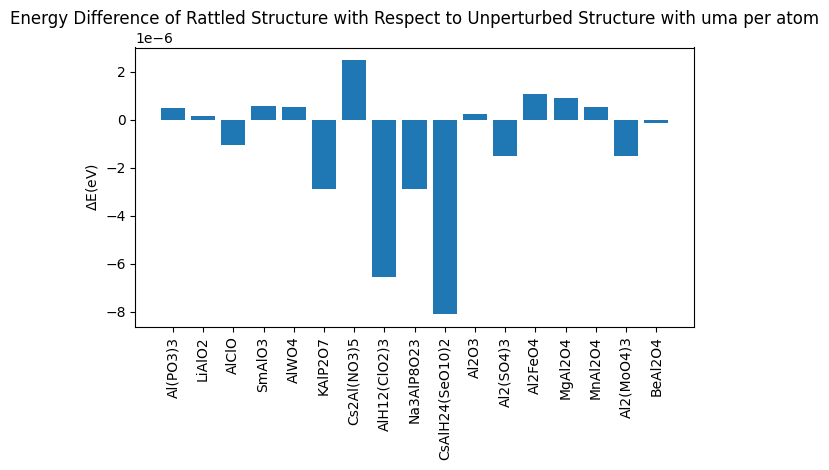

In [35]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title(f"Energy Difference of Rattled Structure with Respect to Unperturbed Structure with {MODEL} per atom")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"../../figures/{MODEL}_corrected_energy_per_atom_difference_plot_{supercell_size}A.png", dpi=300, bbox_inches='tight')

plt.show()